# Data Science Tools 1 - Final Project

Pulling in what we wrote as answers for the 1st hwk for reference:

We aim to analyze the impact of wildfires on daily AQI trends in Colorado over the past decade, focusing on how these events influence air quality across the state. Using air quality data from the EPA’s Air Quality System (AQS), this project will identify temporal patterns and highlight the most affected regions. Special attention will be given to pollutants like PM2.5 and Ozone, which are highly sensitive to wildfire activity. By examining variations in air quality during wildfire seasons, we seek to uncover actionable insights into seasonal and regional pollution dynamics, contributing to a better understanding of the environmental impacts of wildfires in Colorado.

Download the air quality data from the Air Quality System (AQS) website of the U.S. Environmental Protection Agency (EPA) using web scraping and web API, which can be done in two weeks.  
Some data fields or attributes are listed below.

    State Code: The FIPS code of the state in which the monitor resides. (CO = 08)

    County Code: The FIPS code of the county in which the monitor resides.

    Site Num: A unique number within the county identifying the site.

    Date Local: The calendar date for the summary. All daily summaries are for the local standard day (midnight to midnight) at the monitor.

    Latitude and Longitude: Geographic location of the monitoring station.

    AQI: The Air Quality Index value for the day.

    Parameter Code: The AQS code corresponding to the parameter measured by the monitor.

    Parameter Name: The name or description assigned in AQS to the parameter measured by the monitor. Parameters may be pollutants or non-pollutants (e.g. PM2.5, Ozone, etc.).

    Pollutant Standard: Specifies the ambient air quality standard rules used to aggregate statistics. (calculate AQI).

    Units of Measure: The unit of measure for the parameter. QAD always returns data in the standard units for the parameter. Submitters can report data in any unit and the EPA converts it to a standard unit so we may use the data in calculations.

Noise data could come from outliers, missing data, invalid values, or misspellings. So far, we notice that not every air monitor station has a record for every day of the year. Also, as EPA pointed out that some stations collected multiple types of data for air quality (i.e., Ozone, CO, NO2, PM2.5, and PM10) while some situations collected only one type of data. These will be challenges for us to pre-process the data.

Noise in the dataset arises from missing data, as not all monitoring stations record data daily. Additionally, stations often measure different pollutants, leading to inconsistencies when comparing across locations. Outliers, such as unusually high AQI values, may occur due to equipment errors or localized events unrelated to wildfires. Finally, geographic bias exists as monitoring stations are often concentrated in urban areas, potentially underrepresenting rural regions where wildfires are more likely to occur.

Feature engineering opportunities include extracting wildfire season information by identifying months typically associated with wildfire activity (e.g., June–September). Temporal features such as monthly or yearly aggregates, and rolling averages, zcan be created to smooth short-term fluctuations and highlight seasonal trends. Pollutant-specific transformations, such as calculating ratios (e.g., PM2.5/AQI) or isolating key wildfire-related pollutants, will help identify their contributions to air quality degradation. Geospatial aggregation by county or monitoring station will allow for the identification of regions most affected by wildfires. Additionally, AQI values can be re-coded into categorical levels (e.g., “Good,” “Moderate,” “Unhealthy”) to better communicate air quality patterns during wildfire events.

## Package and Path Management



Add proper path variables to the python environment so we can pull in source files and save data and figures.

In [5]:
import os, sys

src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
data_path = os.path.abspath(os.path.join(os.getcwd(), '../data'))
log_path = os.path.abspath(os.path.join(os.getcwd(), '../logs'))
fig_path = os.path.abspath(os.path.join(os.getcwd(), '../figures'))
sys.path.append(src_path)

* **Pandas** - Data manipulation and analysis
* **Matplotlib** - Data visualization
* **Seaborn** - Data visualization
* **OS** - OS functionality
* **Datetime** - Date and time manipulation

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import os
from datetime import datetime
from src.AQS_API import AirQualityCollector
from src.wildfire_data_downloader import WildfireDataDownloader, WildfireDataConverter
import geopandas

## Data Collection

Before talking about the data source and collection process, we can talk about the date range that we're using for the analysis - March 23 - Sept 23 is what's defaulted in the API .py code and not sure if we want to change that, but can justify it here with hsitorical background (e.g. bad year for forest fires, etc.).

I changed it slightly to only look at a month for testing purposes (quicker download).

In [7]:
# Month Range of Interest in YYYYMM format
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)

Background on EPA AQI data and API system for how we're pulling it.

We'll check first to see if we already have a dataset downloaded before we go through the process of downloading it again.

In [11]:
# Check if file already exists
filename = f"Colorado_AQI_{start_date.strftime('%Y%m')}_{end_date.strftime('%Y%m')}.csv"
if os.path.exists(os.path.join(data_path, filename)):
    print(f"File {filename} already present.")
else:
    #Load API from config file
    with open("../src/config.json", "r") as file:
        config = json.load(file)
    API_KEY = config["API_KEY"]
    collector = AirQualityCollector(api_key=API_KEY, start_date=start_date, end_date=end_date)
    collector.collect_data()
    print(f"File {filename} downloaded.")

Data collection finished. Check air_quality_data.log for details.
File Colorado_AQI_202301_202312.csv downloaded.


In [12]:
# Use wildfire data downloader to download 2024 wildfire

download_info = [
        {
            "download_id": "575994",
            "data_source": "modis-c6.1",
            "url": ("https://urldefense.com/v3/__https://firms.modaps.eosdis.nasa.gov/data/download/"
                    "DL_FIRE_M-C61_575994.zip__;!!NCZxaNi9jForCP_SxBKJCA!V6g2hfAXPmWgf7I5lH9wj4Mfl9l-9NzD5-"
                    "Xw7_9qSGknhHOT0__q1KLHus-P_CPWdE-tAgEfdHGVrXmHVmZofQ$")
        }]
wf_downloader = WildfireDataDownloader(download_info, output_dir=data_path)
wf_downloader.run()

ZIP file 'C:\Users\Adam\PycharmProjects\DST1-ForestFireAQI\data\575994_modis-c6.1.zip' already exists. Skipping download.
Extracted ZIP file to 'C:\Users\Adam\PycharmProjects\DST1-ForestFireAQI\data'


## Data Import

We can load the downloaded CSV into a dataframe and start poking around. We can take a peek at the first couple values:

In [14]:
AQI_data = pd.read_csv(os.path.join(data_path, filename))
# Applying the correct variable types to the categories:
AQI_data['Parameter'] = AQI_data['Parameter'].astype('category')
AQI_data.head()

,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category,SiteName,AgencyName,FullAQSCode,IntlAQSCode
0,40.086941,-108.761002,2023-01-01T00:00,OZONE,PPB,35.0,35.0,32,1,"Rangely, CO",National Park Service,081030006,840081030006
1,40.086941,-108.761002,2023-01-01T00:00,PM2.5,UG/M3,5.2,3.0,29,1,"Rangely, CO",National Park Service,081030006,840081030006
2,37.200056,-108.733111,2023-01-01T00:00,OZONE,PPB,-999.0,19.0,-999,-999,Towaoc,Quality Review and Exchange System for Tribes ...,840080838001,840080838001
3,37.349970,-108.587370,2023-01-01T00:00,OZONE,PPB,16.0,22.0,15,1,Cortez Ozone,Colorado Department of Public Health and Envir...,080830006,840080830006
4,39.063599,-108.561096,2023-01-01T00:00,PM2.5,UG/M3,16.8,16.6,65,2,Grand Junction - Powell Building,Colorado Department of Public Health and Envir...,080770017,840080770017


Working next on the wildfire dataset (for reference, confidence is detection confidence percentage, brightness is the brightness temperature of the pixel (K), and frp is fire radiative power(MW)):

In [15]:
# Convert out from json to csv, then read into pandas
wf_converter = WildfireDataConverter(extracted_dir=data_path,
        start_year=2023,
        end_year=2024,
        output_csv=None)
wf_converter.convert_to_csv()
wf_df = pd.read_csv(os.path.join(data_path, "colorado_wildfires_2023_2024.csv"))
# Summarize
wf_df.head()

Reading wildfire JSON data from 'C:\Users\Adam\PycharmProjects\DST1-ForestFireAQI\data\fire_archive_M-C61_575994.json'
Reading wildfire JSON data from 'C:\Users\Adam\PycharmProjects\DST1-ForestFireAQI\data\fire_nrt_M-C61_575994.json'
Saved final wildfire data (with lat/lon) to 'C:\Users\Adam\PycharmProjects\DST1-ForestFireAQI\data\colorado_wildfires_2023_2024.csv'


,StartDate,EndDate,latitude,longitude,acq_date,confidence,brightness,frp
0,2019-01-05,2019-01-05,40.7070,-103.1197,2019-01-05,81,321.6,53.2
1,2019-01-08,2019-01-08,37.0882,-105.0840,2019-01-08,77,316.9,24.3
2,2019-01-29,2019-01-29,38.1084,-103.8768,2019-01-29,57,303.8,11.2
3,2019-02-01,2019-02-01,37.5436,-103.1038,2019-02-01,62,323.3,25.6
4,2019-02-02,2019-02-02,40.5499,-104.8276,2019-02-02,43,301.3,25.2


Now we'll convert each of the datasets (splitting out the AQI data by parameter) into GeoDataSets for easy plotting and manipulation.

## Inital Views
Plotting out a view of all of the stations used to collect data:

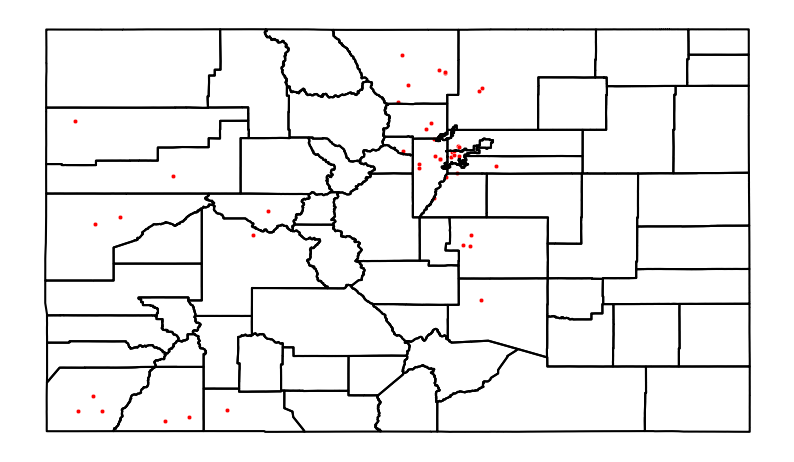

In [16]:
# extract each unique site name with latitude and longitude
site_df = AQI_data[['SiteName', 'Latitude', 'Longitude']].drop_duplicates()
# Plot the site locations on the state map of colorado using the shape file
state_map = geopandas.read_file('../src/County_Data_2020.shp')
fig, ax = plt.subplots(figsize=(10, 10))
state_map.boundary.plot(ax=ax, color="black")
sns.scatterplot(data=site_df, x='Longitude', y='Latitude', c='red', marker="o", s=10)
plt.grid(False)
ax.set_axis_off()
plt.show()

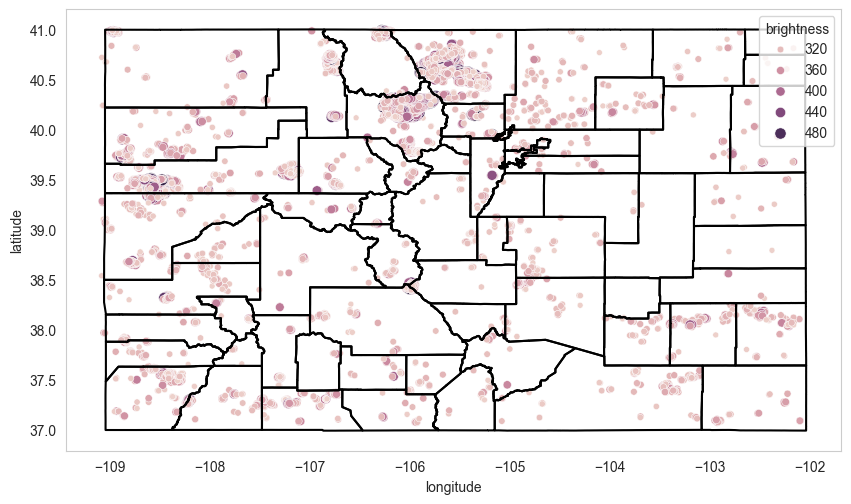

In [17]:
# Geomap of wildfires
fig2, ax2 = plt.subplots(figsize=(10, 10))
state_map.boundary.plot(ax=ax2, color = 'black')
sns.scatterplot(data=wf_df, x='longitude', y='latitude', hue='brightness', size='brightness')
plt.grid(False)
plt.show()